**Author:** [Giuseppe Muschetta](https://github.com/peppe212)
**Python version:** 3.11

# CLASSIFICATION

### We will classify earthquakes according to this:

**Less Severe**: This category includes earthquakes that might be felt but rarely cause damage. 
It combines the original categories of "Very Minor", "Minor", "Light", and "Moderate". 
These earthquakes can cause noticeable shaking but typically do not lead to significant damage to buildings and other structures.

**More Severe**: This category encompasses the original "Strong", "Very Strong", "Major", and "Devastating" classifications.
Earthquakes in this category can cause serious damage in extensive areas. They are capable of causing severe damage in very wide areas, 
potentially affecting several hundreds or thousands of kilometers. 
These are the types of earthquakes that often lead to significant structural damage and can have far-reaching impacts.



In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc
# per visualizzare il decision tree usando totalmente spark
import graphviz

from pyspark.sql.functions import (
    col,
    udf,
    unix_timestamp
)

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# CONFIGURAZIONE DEI VARI PATH
input_dataset_path = "./dataset/earthquakes_prepared_outliered_kmeans_labeled.csv"
images_path = "./images/classification/"

In [4]:
# STARTING SPARK SESSION:

spark = (SparkSession
         .builder
         .master('local[*]')  
         .appName("Project")
         .config("spark.driver.memory", "4g")  
         .config("spark.executor.memory", "4g")  
         .config("spark.driver.maxResultSize", "2g")  
         #.config("spark.sql.repl.eagerEval.enabled", "True")  
         # Usa il garbage collector G1
         .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")  
         .getOrCreate())

# sopprime i fastidiosissimi warning
spark.sparkContext.setLogLevel("ERROR")

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 20:05:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Leggiamo il dataset cleaned contenente le etichette del clustering eseguito con k-means
df = spark.read.option("escape","\"").csv(
    input_dataset_path, 
    header=True, 
    inferSchema=True,
    # timestampFormat="yyyy-MM-dd" # per informare il parser circa il formato di timestamp
)

In [6]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|kmeans_labels|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|            5|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|            5|
|1972-11-21 10:27:...|        

In [7]:
df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)
 |-- kmeans_labels: integer (nullable = true)


## Preprocessing before classification

/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


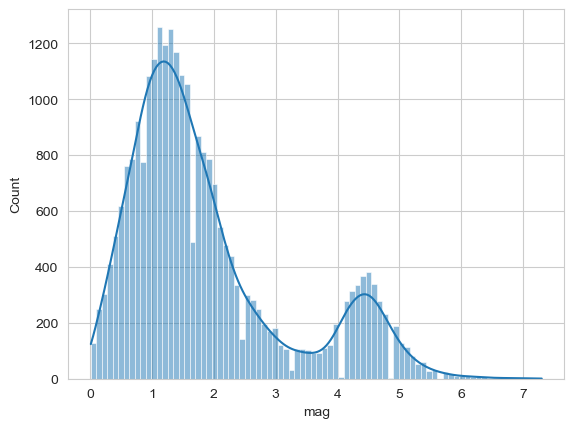

In [8]:
# plottiamo la distribuzione della variabile mag che andremo a discretizzare per la classificazione
# trattasi di distribuzione bimodale, questo ci fa capire proprio come si distribuiscono 
# naturalmente le due tipologie di terremoti in base alla loro magnitudo.
df_mag = df.select('mag').sample(0.01)
df_pandas_mag = df_mag.toPandas()

sns.histplot(df_pandas_mag, x='mag', kde=True)
plt.savefig(images_path + 'mag_distribution.png')
plt.show()

In [9]:
# l'idea attuale è quella di discretizzare la colonna mag in due categorie con la seguente funzione:
def categorize_magnitude(mag):
    if mag < 3:
        return "Less Severe"
    else:
        return "More Severe"

# La funzione udf() di Spark converte la funzione Python categorize_magnitude in una UDF che può essere 
# utilizzata in un dataframe Spark. StringType() specifica che l'output dell'UDF sarà una stringa.
mag_udf = udf(categorize_magnitude, StringType())
# TRADUCO DALLA DOCUMENTAZIONE: Nel contesto di Apache Spark, StringType() è un tipo di dato utilizzato 
# per specificare il tipo di dati che ci si aspetta venga restituito da una User-Defined Function (UDF). 
# Quando definisci un'UDF in Spark, puoi opzionalmente specificare il tipo di ritorno. 
# Questo aiuta Spark a ottimizzare l'esecuzione e a gestire i dati in modo più efficace.

# Applico la UDF al dataframe
# Sostanzialmente crea una nuova colonna chiamata 'mag_class' e applica la udf ad ogni elemento della colonna mag
# Per ogni valore della colonna mag avremo la categorizzazione appropriata.
df = df.withColumn("mag_class", mag_udf(df["mag"]))

In [10]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+-----------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|kmeans_labels|  mag_class|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+-----------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|            5|Less Severe|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8

In [11]:
# Conto il numero di terremoti in ogni categoria
category_counts = df.groupBy("mag_class").count().orderBy(col("count").desc())
category_counts.show()

# Notiamo uno sbilanciamento della classe piu' rara ("More severe") che codificheremo con 1
# il che è positivo perchè rende le cose piu' frizzanti, infatti avendo classi sbilanciate 
# l'accuracy da sola non servirà piu' univocamente a determinare la bontà del modello.
# Concetti come precision (soprattutto nel nostro caso nel predire terremoti potenzialmente pericolosi), 
# recall e la loro media armonica F1_score acquisiscono una notevole importanza.
# La confusion matrix ci darà informazioni sui FN, FP, TN e TP e la ROC Curve ci darà ulteriori 
# informazioni circa la buona riuscita del modello che andremo a creare con un singolo DT e una Foresta di DT.

+-----------+-------+
|  mag_class|  count|
+-----------+-------+
|Less Severe|2148488|
|More Severe| 459068|
+-----------+-------+


In [12]:
# Raggruppo per la colonna 'kmeans_labels' e conta le occorrenze
conteggio = df.groupBy("kmeans_labels").count()
conteggio.show()

+-------------+-------+
|kmeans_labels|  count|
+-------------+-------+
|            1| 199238|
|            6|   4612|
|            3|  25368|
|            5| 472058|
|            4| 469400|
|            7| 169897|
|            2|  38944|
|            0|1228039|
+-------------+-------+


In [13]:
# Converto le colonne 'time' e 'updated' in timestamp Unix, cioè il tempo in secondi trascorsi dal 1970
df = df.withColumn("time_unix", unix_timestamp("time"))
df = df.withColumn("updated_unix", unix_timestamp("updated"))

# elimino le colonne originali time e updated
df = df.drop('time', 'updated')

# rinomino le colonne 'time_unix' e 'time_updated' in quelle originali 'time' e 'updated'
df = df.withColumnRenamed("time_unix", "time")
df = df.withColumnRenamed("updated_unix", "updated")

In [14]:
df.show(10)

+------------------+-------------------+------------------+----+-------+-----+-------------------+----+--------------------+----+------+-------------+-----------+---------+----------+
|          latitude|          longitude|             depth| mag|magType|  gap|               dmin| rms|               place| nst|magNst|kmeans_labels|  mag_class|     time|   updated|
+------------------+-------------------+------------------+----+-------+-----+-------------------+----+--------------------+----+------+-------------+-----------+---------+----------+
|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|             0.4872|0.12|          Washington| 7.0|   7.0|            5|Less Severe| 61022586|1469404317|
|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|            0.03549|0.12|          Washington| 8.0|   8.0|            5|Less Severe| 90666668|1469404671|
|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0|  

In [15]:
# Continuiamo a fare il preprocessing del dataframe per i modelli di machine learning che seguiranno

# Colonne categoriche e numeriche da usare per la classificazione e da inserire poi nel vector assembler
# sottoforma di colonna 'features' che le racchiuderà tutte.
categorical_cols = ['magType', 'kmeans_labels']
numerical_cols = ['latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms', 'nst', 'magNst', 'time', 'updated']

# Elenco di StringIndexer per le variabili categoriche
# Lo StringIndexer indicizza le variabili categoriche, poi se esse sono nominale si fa la OHE
# Se esse sono ordinali, ergo vi è un ordine intrinseco tra loro, allora non si fa la OHE
# Nel nostro caso sia magType che le etichette del clustering non sono ordinali, ergo verranno OHEed
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in categorical_cols]

# Elenco di OneHotEncoders per le variabili categoriche nominali indicizzate
encoders = [OneHotEncoder(inputCol=idx.getOutputCol(), outputCol=idx.getOutputCol() + "_ohe") for idx in indexers]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")


assemblerInputs = [e.getOutputCol() for e in encoders] + ["scaled_numerical_features"]
final_assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Creo una pipeline che include gli indexers, gli encoders, il VectorAssembler per le numeriche, 
# lo scaler e il VectorAssembler finale
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, final_assembler])

# Applico il preprocessing
df_transformed = pipeline.fit(df).transform(df)

# Dobbiamo adesso trasformare la colonna target e mappare a interi le sue categorie tramite StringIndexer
# Trasformazione della colonna target 'mag_class' in valori interi
target_indexer = StringIndexer(inputCol='mag_class', outputCol='mag_class_indexed')
df_final = target_indexer.fit(df_transformed).transform(df_transformed)

# droppiamo le colonne inutili ai fini della classificazione
# Elenco delle colonne da rimuovere:
columns_to_drop = ['magType_indexed', 'kmeans_labels_indexed', 'magType_indexed_ohe', 
                   'kmeans_labels_indexed_ohe', 'numerical_features', 'scaled_numerical_features']

df_final = df_final.drop(*columns_to_drop)

df_final = df_final.withColumnRenamed('mag_class', 'mag_categories')

df_final = df_final.withColumnRenamed('mag_class_indexed', 'class')

# lo stringindexer mappa le categorie dalla piu' frequente che prende zero alla piu' rara che prende il valore piu' alto, 
# in questo caso 1 per i terremoti con magnitudo piu' alta

In [16]:
df_final.show(truncate=False)

+------------------+-------------------+------------------+----+-------+-----+--------------------+----+-------------------------------------+----+------+-------------+--------------+---------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|latitude          |longitude          |depth             |mag |magType|gap  |dmin                |rms |place                                |nst |magNst|kmeans_labels|mag_categories|time     |updated   |features                                                                                                                                                                                                                                  |class|
+------------------+-------------------+------------------+----+-------+-----+--------------------+----+----

In [17]:
# questo è il dataframe pronto per la classificazione con algoritmi di tipo decision tree o foreste:
df_final.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)
 |-- kmeans_labels: integer (nullable = true)
 |-- mag_categories: string (nullable = true)
 |-- time: long (nullable = true)
 |-- updated: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- class: double (nullable = false)


In [18]:
df_final.count()

2607556

### CLASSIFICATION WITH A DECISION TREE CLASSIFIER:

In [19]:
# ora che il preprocessing è terminato, il dataframe è pronto per essere utilizzato dai modelli di ml
# INIZIAMO LA CLASSIFICAZIONE UTILIZZANDO UN SINGOLO DECISION TREE:

# Variabile target
target = 'class'

# Divisione del dataset Paretica: 80% training e 20% test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Creazione del Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol=target,)

# Creazione della ParamGrid per la Cross Validation
# Se aggiungo parametri alle liste della griglia, ottengo il classico Connection Refused (la macchina non ce la fa...)
# Cioè termino le risorse della macchina e va tutto in blocco.
dtparamGrid = (ParamGridBuilder()
               .addGrid(dt.impurity, ['gini']) # ['gini', 'entropy']
               .addGrid(dt.maxDepth, [5]) # [5, 10, 15, 20, 30, 50]
               .addGrid(dt.maxBins, [32]) # [16, 32, 64, 128]
               .addGrid(dt.minInstancesPerNode, [3]) # [1, 2, 3, 5, 7]
               .addGrid(dt.minInfoGain, [0.0]) # [0.0, 0.1, 0.3]
               .addGrid(dt.minWeightFractionPerNode, [0])
               .addGrid(dt.maxMemoryInMB, [256]) # [256, 512, 1024, 2048, 4096]
               .addGrid(dt.cacheNodeIds, [False]) # [True, False]
               .addGrid(dt.seed, [42])
               .build())

# Valutatore per la Cross Validation
dtcvEvaluator = BinaryClassificationEvaluator(labelCol=target, 
                                              rawPredictionCol="probability", 
                                              metricName="areaUnderROC")

# Creazione del CrossValidator
dtcv = CrossValidator(estimator=dt,
                      estimatorParamMaps=dtparamGrid,
                      evaluator=dtcvEvaluator,
                      seed=42,
                      parallelism=1,
                      numFolds=4)

# Addestramento del modello con la Cross Validation
dtcvModel = dtcv.fit(train_data)

# Previsioni sul test set
predictions = dtcvModel.transform(test_data)

# Valutazione del modello
auc_ = dtcvEvaluator.evaluate(predictions)
# print("Area Under ROC: ", auc_)

# Valutazione aggiuntiva con MulticlassClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

# Output delle metriche aggiuntive
print(f"Area Under ROC: {auc_}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

# Calcolo della matrice di confusione
predictionAndLabels = predictions.select("prediction", target).rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()

# Estrazione dei valori dalla matrice di confusione
tn, fp, fn, tp = confusion_matrix.ravel()

# Stampa della matrice di confusione
print(f"Confusion Matrix:")
print(f"          Predicted: 0 Predicted: 1")
print(f"Actual: 0   TN: {tn}      FP: {fp}")
print(f"Actual: 1   FN: {fn}      TP: {tp}")

# Nuova soglia di probabilità
# Tale soglia viene utilizzata per aumentare la quantità di FN rilevati e migliorare
# l'efficienza del classificatore
new_probability_threshold = 0.3

# UDF per estrarre la probabilità della classe positiva
def extract_prob(value):
    return float(value[1])

# specifico che la funzione definita dall'utente (udf) 
# restituirà un valore in virgola mobile e non un intero
extract_prob_udf = udf(extract_prob, DoubleType()) 

# Applicazione della nuova soglia di probabilità
new_predictions = predictions.withColumn('new_prediction', extract_prob_udf(col('probability')) >= new_probability_threshold)
new_predictions = new_predictions.withColumn('new_prediction', col('new_prediction').cast('double'))

# Calcolo della nuova matrice di confusione
new_predictionAndLabels = new_predictions.select("new_prediction", target).rdd.map(lambda x: (x[0], x[1]))
new_metrics = MulticlassMetrics(new_predictionAndLabels)
new_confusion_matrix = new_metrics.confusionMatrix().toArray()

# Estrazione dei valori dalla nuova matrice di confusione
new_tn, new_fp, new_fn, new_tp = new_confusion_matrix.ravel()

print(f"UPDATED Confusion Matrix with new probability Threshold = {new_probability_threshold}:")
print(f"          Predicted: 0 Predicted: 1")
print(f"Actual: 0   TN: {new_tn}      FP: {new_fp}")
print(f"Actual: 1   FN: {new_fn}      TP: {new_tp}")
print(f"This approach is useful when positive class is very imbalanced")


# abbassando la soglia di probabilità  abbiamo migliorato il classificatore 
# infatti si è ridotto il totale di falsi negativi, il che è di cruciale importanza.

/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area Under ROC: 0.9693587079584068
Accuracy: 0.9785664386663903
Precision: 0.9785359092290496
Recall: 0.9785664386663903
F1 Score: 0.9782148783792506


Confusion Matrix:
          Predicted: 0 Predicted: 1
Actual: 0   TN: 427506.0      FP: 1963.0
Actual: 1   FN: 9205.0      TP: 82378.0


UPDATED Confusion Matrix with new probability Threshold = 0.3:
          Predicted: 0 Predicted: 1
Actual: 0   TN: 426997.0      FP: 2472.0
Actual: 1   FN: 8864.0      TP: 82719.0
This approach is useful when positive class is very imbalanced


In [20]:
# Usando Spark plottiamo l'albero di decisione testuale

# Ottenere il miglior modello dal CrossValidator
best_model = dtcvModel.bestModel

# Ottenere la rappresentazione in stringa dell'albero di decisione
treeString = best_model.toDebugString
print(treeString)


# vediamo il decision tree come una serie di if-then-else clauses
# la cosa positiva è che l'albero consta solo di 5 livelli (max_depth = 5 nel pre-pruning) e 41 nodi 
# ha utilizzato gran parte degli attributi predictors e, il fatto che non sia molto complesso a livello di struttura, 
# significa che non ha overfittato l'insieme di training e non si è quindi adattato 
# a caratteristiche intrinseche che impediscono di generalizzare bene come il rumore nei dati...

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5ac8543a306d, depth=5, numNodes=41, numClasses=2, numFeatures=19
  If (feature 10 <= -1.1221122261784475)
   If (feature 9 <= 0.716696959741318)
    Predict: 1.0
   Else (feature 9 > 0.716696959741318)
    If (feature 15 <= 1.5700413360161598)
     If (feature 15 <= 1.4161862577767224)
      If (feature 5 in {1.0})
       Predict: 1.0
      Else (feature 5 not in {1.0})
       Predict: 0.0
     Else (feature 15 > 1.4161862577767224)
      If (feature 10 <= -1.449408895506168)
       Predict: 0.0
      Else (feature 10 > -1.449408895506168)
       Predict: 1.0
    Else (feature 15 > 1.5700413360161598)
     If (feature 14 <= 1.0119643269431955)
      If (feature 16 <= 0.4168702989684304)
       Predict: 1.0
      Else (feature 16 > 0.4168702989684304)
       Predict: 0.0
     Else (feature 14 > 1.0119643269431955)
      Predict: 1.0
  Else (feature 10 > -1.1221122261784475)
   If (feature 1 in {1.0})
    If (feature 15 <= 1.416

In [21]:
# Creazione manuale dell'albero decisionale in formato DOT
decision_tree_dot = """
digraph Tree {
node [shape=box] ;
0 [label="feature 10 <= -0.971"] ;
1 [label="feature 9 <= 0.713"] ;
0 -> 1 [label="yes"] ;
2 [label="feature 1 in {1.0}"] ;
1 -> 2 [label="yes"] ;
3 [label="feature 12 <= 2.526"] ;
2 -> 3 [label="yes"] ;
4 [label="Predict: 1.0"] ;
3 -> 4 [label="yes"] ;
5 [label="feature 15 <= 1.175"] ;
3 -> 5 [label="no"] ;
6 [label="Predict: 0.0"] ;
5 -> 6 [label="yes"] ;
7 [label="Predict: 1.0"] ;
5 -> 7 [label="no"] ;
8 [label="Predict: 1.0"] ;
2 -> 8 [label="no"] ;
9 [label="feature 9 > 0.713"] ;
0 -> 9 [label="no"] ;
10 [label="feature 15 <= 1.571"] ;
9 -> 10 [label="yes"] ;
11 [label="feature 15 <= 1.415"] ;
10 -> 11 [label="yes"] ;
12 [label="Predict: 0.0"] ;
11 -> 12 [label="yes"] ;
13 [label="feature 10 <= -1.448"] ;
11 -> 13 [label="no"] ;
14 [label="Predict: 0.0"] ;
13 -> 14 [label="yes"] ;
15 [label="Predict: 1.0"] ;
13 -> 15 [label="no"] ;
16 [label="feature 15 > 1.571"] ;
10 -> 16 [label="no"] ;
17 [label="feature 14 <= 0.979"] ;
16 -> 17 [label="yes"] ;
18 [label="feature 16 <= 0.417"] ;
17 -> 18 [label="yes"] ;
19 [label="Predict: 1.0"] ;
18 -> 19 [label="yes"] ;
20 [label="Predict: 0.0"] ;
18 -> 20 [label="no"] ;
21 [label="Predict: 1.0"] ;
17 -> 21 [label="no"] ;
22 [label="feature 10 > -0.971"] ;
0 -> 22 [label="no"] ;
23 [label="feature 1 in {1.0}"] ;
22 -> 23 [label="yes"] ;
24 [label="feature 15 <= 1.415"] ;
23 -> 24 [label="yes"] ;
25 [label="feature 9 <= 2.008"] ;
24 -> 25 [label="yes"] ;
26 [label="feature 15 <= 1.175"] ;
25 -> 26 [label="yes"] ;
27 [label="Predict: 0.0"] ;
26 -> 27 [label="yes"] ;
28 [label="Predict: 1.0"] ;
26 -> 28 [label="no"] ;
29 [label="Predict: 0.0"] ;
25 -> 29 [label="no"] ;
30 [label="feature 15 > 1.415"] ;
24 -> 30 [label="no"] ;
31 [label="feature 11 <= 1.442"] ;
30 -> 31 [label="yes"] ;
32 [label="Predict: 1.0"] ;
31 -> 32 [label="yes"] ;
33 [label="feature 15 <= 1.571"] ;
31 -> 33 [label="no"] ;
34 [label="Predict: 0.0"] ;
33 -> 34 [label="yes"] ;
35 [label="Predict: 1.0"] ;
33 -> 35 [label="no"] ;
36 [label="feature 1 not in {1.0}"] ;
22 -> 36 [label="no"] ;
37 [label="feature 0 in {1.0}"] ;
36 -> 37 [label="yes"] ;
38 [label="feature 15 <= 1.263"] ;
37 -> 38 [label="yes"] ;
39 [label="feature 16 <= 0.480"] ;
38 -> 39 [label="yes"] ;
40 [label="Predict: 0.0"] ;
39 -> 40 [label="yes"] ;
41 [label="Predict: 1.0"] ;
39 -> 41 [label="no"] ;
42 [label="Predict: 1.0"] ;
38 -> 42 [label="no"] ;
43 [label="Predict: 1.0"] ;
37 -> 43 [label="no"] ;
44 [label="Predict: 1.0"] ;
36 -> 44 [label="no"] ;
}
"""

# Renderizza e salva in un file l'albero decisionale
graph = graphviz.Source(decision_tree_dot)
graph.render(images_path + "decisionTree_graphviz", format='png', cleanup=True)


'images/classification/decisionTree_graphviz.png'

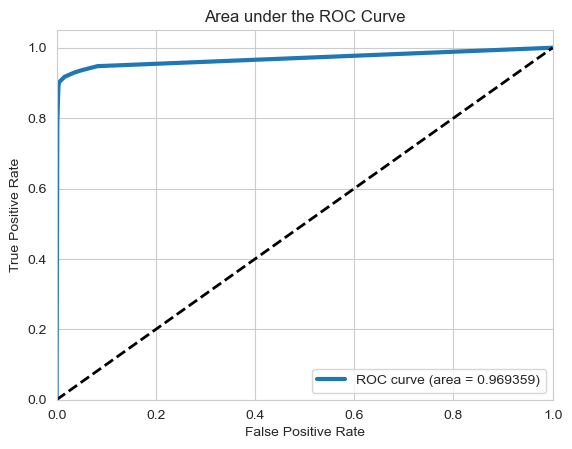

In [22]:
# CALCOLO E VISUALIZZO LA ROC CURVE

# Seleziono le probabilità e la variabile target dal dataframe delle previsioni
results = predictions.select(['probability', target])

# Preparazione del set di punteggio-etichetta
results_collect = results.collect()
results_list = [(float(i[0][1]), float(i[1])) for i in results_collect]

# Creazione delle liste per test e punteggio
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

# Calcolo della curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Visualizzazione della curva ROC
plt.figure()
# lw è la larghezza della linea
plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc, lw=3)  
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.savefig(images_path + 'DecisionTree_ROC_Curve.png')  
plt.show()


### RANDOM FOREST CLASSIFIER

/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Best Model Metrics:
Best Model Area Under ROC: 0.991484542256893
Accuracy: 0.9834795759348395
Precision: 0.9835176600303681
Recall: 0.9834795759348395
F1 Score: 0.9832477448087142


Confusion Matrix for Best Model:
          Predicted: 0 Predicted: 1
Actual: 0   TN: 428286.0      FP: 1183.0
Actual: 1   FN: 7425.0      TP: 84158.0


UPDATED Confusion Matrix with new probability Threshold = 0.3:
          Predicted: 0 Predicted: 1
Actual: 0   TN: 426011.0      FP: 3458.0
Actual: 1   FN: 5368.0      TP: 86215.0
This approach is useful when the positive class is very imbalanced


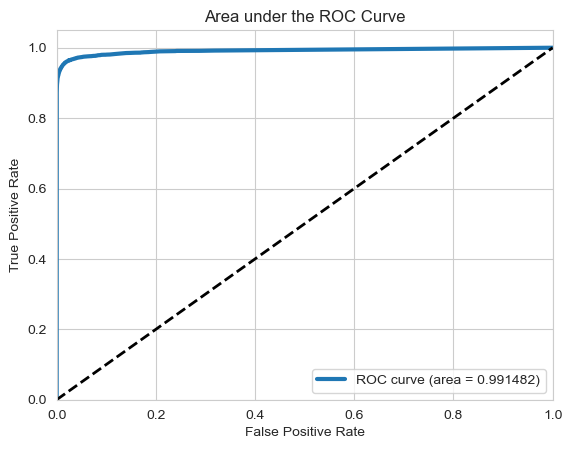

In [23]:
target = 'class'  
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.maxDepth, [10]) \
    .addGrid(rf_classifier.impurity, ['gini']) \
    .addGrid(rf_classifier.numTrees, [10]) \
    .addGrid(rf_classifier.bootstrap, [True]) \
    .addGrid(rf_classifier.featureSubsetStrategy, ['auto']) \
    .addGrid(rf_classifier.minInstancesPerNode, [50]) \
    .addGrid(rf_classifier.maxMemoryInMB, [256]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol=target, 
                                          rawPredictionCol="probability", 
                                          metricName="areaUnderROC")

crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4,
                          seed=42)

# Eseguo la cross-validation sul set di addestramento per trovare il miglior modello
cv_model = crossval.fit(train_data)

# Seleziono il miglior modello
best_rf_model = cv_model.bestModel

# Predizioni sul set di test utilizzando il miglior modello
cv_predictions = best_rf_model.transform(test_data)


cv_auc_score = evaluator.evaluate(cv_predictions)
#print("Best Model Area Under ROC: ", cv_auc_score)

# Utilizza MulticlassClassificationEvaluator per valutare precision, recall, e F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
cv_accuracy = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "accuracy"})
cv_precision = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "weightedPrecision"})
cv_recall = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "weightedRecall"})
cv_f1 = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "f1"})

print(f"Best Model Metrics:")
print(f"Best Model Area Under ROC: {cv_auc_score}\nAccuracy: {cv_accuracy}\nPrecision: {cv_precision}\nRecall: {cv_recall}\nF1 Score: {cv_f1}")

cv_predictionAndLabels = cv_predictions.select("prediction", target).rdd.map(lambda x: (float(x[0]), float(x[1])))
cv_metrics = MulticlassMetrics(cv_predictionAndLabels)
cv_confusion_matrix = cv_metrics.confusionMatrix().toArray()

cv_tn, cv_fp, cv_fn, cv_tp = cv_confusion_matrix.ravel()
print(f"Confusion Matrix for Best Model:")
print(f"          Predicted: 0 Predicted: 1")
print(f"Actual: 0   TN: {cv_tn}      FP: {cv_fp}")
print(f"Actual: 1   FN: {cv_fn}      TP: {cv_tp}")

new_prob_threshold = 0.3
extract_prob_udf = udf(lambda value: float(value[1]), DoubleType())

cv_predictions_with_new_threshold = cv_predictions.withColumn('new_prediction', extract_prob_udf(col('probability')) >= new_prob_threshold)
cv_predictions_with_new_threshold = cv_predictions_with_new_threshold.withColumn('new_prediction', col('new_prediction').cast('double'))

new_predictionAndLabels = cv_predictions_with_new_threshold.select("new_prediction", target).rdd.map(lambda x: (x[0], x[1]))
new_metrics = MulticlassMetrics(new_predictionAndLabels)
new_confusion_matrix = new_metrics.confusionMatrix().toArray()

new_tn, new_fp, new_fn, new_tp = new_confusion_matrix.ravel()

print(f"UPDATED Confusion Matrix with new probability Threshold = {new_prob_threshold}:")
print(f"          Predicted: 0 Predicted: 1")
print(f"Actual: 0   TN: {new_tn}      FP: {new_fp}")
print(f"Actual: 1   FN: {new_fn}      TP: {new_tp}")
print(f"This approach is useful when the positive class is very imbalanced")

best_model_results = cv_predictions.select(['probability', target])
best_model_results_collect = best_model_results.collect()
best_model_results_list = [(float(i[0][1]), float(i[1])) for i in best_model_results_collect]
y_test = [i[1] for i in best_model_results_list]
y_score = [i[0] for i in best_model_results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc, lw=3)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.savefig(images_path + 'forest_ROC_curve.png')
plt.show()


In [24]:
spark.stop()